# Predicting Bitcoin Price

The ability to predict the movement of financial assets has been one of the most coveted things ever since the birth of the financial markets as we know them. Humans have developed many techniques in order to help them in that process, the most popular being the fundamental and technical analysis. No matter which techniques we would use, the final decision, of going long or short on an asset, is fully dependant on a person's choice which could be subjective, due to some kind of bias in one's sentiment. 
<br>How could we make such a decision more objective?
<br>The answer is quite simple: we could incorporate the cutting-edge technology of Recurrent Neural Network and leave the decision to an algorithm. And this article leads us through the process of setting up such a network and all the tasks that are needed to accomplish it.
<br>There are some steps that we have to go through to get as past the finish line, the first being data acquisition and preparation. This may seem as a 'not so crucial' step, but the fact is that the most work is done (or should be done) working on the data and preparing it properly. As as *Data Scientist* we have to go through the data line by line (almost literally) and see what a dataset holds inside. If we go through this step correctly we are on our way for glory. Cryptocurrencies are based on blockchain technology in which all the information is transparent. We can get the information concerning number of transactions, their magnitude, and so on. In this article we are going to see if these datasets can help us in predicting future Bitcoin price.
<br>The second step is to make a benchmark for our endavour. In this article we use a very widely used model when it comes to forecasting timeseries - the VARMAX model. This model is a combination of the ARMAX and VAR models, and is usually considered to be one of the best 'standard' models in financial time series prediction. This step is just to make sure that it is worhwile to set up such complicated neural network.
<br>The third step is the most imporant thing (in context of this text) - setting up the Recurrent Neural Network with the use of GRU (Gated Recurrent Unit) cells. We chose the GRU cells over the LSTM cells just because the literature indicate that they both yield similar results, while the GRU cell is less complicated (uses fewer gates). 
<br>The last step is forecasting future values using both models, and comparing the obtained results to see if using Machine Learning algorithms was necessary and helpful in our case.

## Imports

We start with importing all the necessary modules.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop, Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from bs4 import BeautifulSoup
import re
import datetime
import requests
import statsmodels as sm
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Data acquisition and preparation

We are going to get the data we are interested in from *bitinfocharts.com*. It is a site that provides information and statistics about cryptocurrency market. We are interested in all the stats concerning Bitcoin. We set up a get_data function in which we go through the website written in html. We will use the Beautiful Soup module in order to do that. We put all the data in to a `pandas DataFrame` and make sure that we set the index to be pandas `DatetimeIndex`.

In [0]:
def get_data():
    baseurl = 'https://bitinfocharts.com/comparison/'
    btcurllist = [
        'bitcoin-price.html',
        'bitcoin-transactions.html',
        'size-btc.html',
        'sentbyaddress-btc.html',
        'bitcoin-difficulty.html',
        'bitcoin-hashrate.html',
        'bitcoin-mining_profitability.html',
        'sentinusd-btc.html',
        'bitcoin-transactionfees.html',
        'bitcoin-median_transaction_fee.html',
        'bitcoin-confirmationtime.html',
        'bitcoin-marketcap.html',
        'transactionvalue-btc.html',
        'mediantransactionvalue-btc.html',
        'tweets-btc.html',
        'activeaddresses-btc.html',
        'top100cap-btc.html']
    full = {}
    namelist = []
    for t in range (0, len(btcurllist)):
        url = baseurl + btcurllist[t]
        name = btcurllist[t][:-5].replace('-','_')
        namelist.append(name)
        r = requests.get(url)
        data = r.text
        soup = BeautifulSoup(data, "html.parser")
        text = soup.get_text()
        p = 0
        lista = []
        for i in range(p, len(text)):
            text = text[p:]
            m = re.search("new Date", text)
            if m == None:
                break
            start = m.end() + 2
            end = start + 10
            newstr = text[start:end]
            p = end + 1
            if newstr[0:2] != '20':
                continue
            rok = int(newstr[0:4])
            miesiac = int(newstr[5:7])
            dzien = int(newstr[8:10])
            data = datetime.date(rok, miesiac, dzien)
            text = text[p:]
            n = re.search(",", text)
            b = re.search("]", text)
            start1 = n.end()
            end1 = b.start()
            newstr2 = text[start1:end1]
            if "." in newstr2:
                dane = np.float32(newstr2)
            elif newstr2 == 'null':
                dane = newstr2 = np.nan
            else:
                dane = np.float32(newstr2)
            p = end1
            wynik = [
                data,
                dane]
            lista.append(wynik)
        lista = np.array(lista)
        df = pd.DataFrame(lista[:,1], columns = [name], index = pd.DatetimeIndex(lista[:,0]))
        full[name] = df
    df = pd.concat([full.get(namelist[0]), full.get(namelist[1]), full.get(namelist[2]), full.get(namelist[3]), full.get(namelist[4]), full.get(namelist[5]), full.get(namelist[6]), full.get(namelist[7]), full.get(namelist[8]), full.get(namelist[9]), full.get(namelist[10]), full.get(namelist[11]), full.get(namelist[12]), full.get(namelist[13]), full.get(namelist[14]), full.get(namelist[15]), full.get(namelist[16])], axis=1)
    return df

In [0]:
df = get_data()

Now that we downloaded the data, let's take a look at it.

In [0]:
df.head()

,bitcoin_price,bitcoin_transactions,size_btc,sentbyaddress_btc,bitcoin_difficulty,bitcoin_hashrate,bitcoin_mining_profitability,sentinusd_btc,bitcoin_transactionfees,bitcoin_median_transaction_fee,bitcoin_confirmationtime,bitcoin_marketcap,transactionvalue_btc,mediantransactionvalue_btc,tweets_btc,activeaddresses_btc,top100cap_btc
2009-01-03,NaN,NaN,204,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can see that the first observation comes from 2009-01-03 and most of that the data is `numpy NaN`. Now let's take a look at the datatype of out dataframe:

In [0]:
df.dtypes

bitcoin_price                     object
bitcoin_transactions              object
size_btc                          object
sentbyaddress_btc                 object
bitcoin_difficulty                object
bitcoin_hashrate                  object
bitcoin_mining_profitability      object
sentinusd_btc                     object
bitcoin_transactionfees           object
bitcoin_median_transaction_fee    object
bitcoin_confirmationtime          object
bitcoin_marketcap                 object
transactionvalue_btc              object
mediantransactionvalue_btc        object
tweets_btc                        object
activeaddresses_btc               object
top100cap_btc                     object
dtype: object

As we can see all of the columns have the `object` dtype. For the sake of our analysis we need to change that `dtype` to numeric.

In [0]:
df[df.columns] = df[df.columns].apply(pd.to_numeric, errors='coerce')

In [0]:
df.dtypes

bitcoin_price                     float64
bitcoin_transactions              float64
size_btc                          float64
sentbyaddress_btc                 float64
bitcoin_difficulty                float64
bitcoin_hashrate                  float64
bitcoin_mining_profitability      float64
sentinusd_btc                     float64
bitcoin_transactionfees           float64
bitcoin_median_transaction_fee    float64
bitcoin_confirmationtime          float64
bitcoin_marketcap                 float64
transactionvalue_btc              float64
mediantransactionvalue_btc        float64
tweets_btc                        float64
activeaddresses_btc               float64
top100cap_btc                     float64
dtype: object

Let's make sure that our index is set to datetime.

In [0]:
df.index

DatetimeIndex(['2009-01-03', '2009-01-04', '2009-01-05', '2009-01-06',
               '2009-01-07', '2009-01-08', '2009-01-09', '2009-01-10',
               '2009-01-11', '2009-01-12',
               ...
               '2018-07-22', '2018-07-23', '2018-07-24', '2018-07-25',
               '2018-07-26', '2018-07-27', '2018-07-28', '2018-07-29',
               '2018-07-30', '2018-07-31'],
              dtype='datetime64[ns]', length=3497, freq='D')

We have seen that our dataframe is full of NaNs when we took a look at its head. As we are interested in predicitng the price of Bitcoin, the price column is what we will focus for now. Let's see when is the first valid price data.

In [0]:
df.bitcoin_price.first_valid_index()

Timestamp('2010-07-17 00:00:00', freq='D')

In [0]:
df.bitcoin_price.loc['2010-07-16':'2010-07-18']

2010-07-16       NaN
2010-07-17    0.0495
2010-07-18    0.0726
Freq: D, Name: bitcoin_price, dtype: float64

The first observation of price comes from 2010-07-17. So we get rid of all the data that is before this date.

In [0]:
df = df.truncate('2010-07-17')

In [0]:
df.head()

,bitcoin_price,bitcoin_transactions,size_btc,sentbyaddress_btc,bitcoin_difficulty,bitcoin_hashrate,bitcoin_mining_profitability,sentinusd_btc,bitcoin_transactionfees,bitcoin_median_transaction_fee,bitcoin_confirmationtime,bitcoin_marketcap,transactionvalue_btc,mediantransactionvalue_btc,tweets_btc,activeaddresses_btc,top100cap_btc
2010-07-17,0.0495,235.0,649.653015,390.0,181.542999,2.775561e+09,154298.0,1193.0,0.000010,NaN,8.324,169839.0,2.924,0.248,NaN,804.0,25.749001
2010-07-18,0.0726,248.0,765.284973,424.0,181.542999,1.554461e+09,401834.0,2620.0,0.000243,NaN,8.372,249761.0,6.237,0.363,NaN,917.0,25.782000
2010-07-19,0.0859,354.0,756.039978,553.0,181.542999,1.551288e+09,481473.0,4048.0,0.000022,NaN,8.276,295981.0,7.666,0.429,NaN,972.0,25.684999
2010-07-20,0.0783,413.0,984.706970,632.0,181.542999,1.640430e+09,431831.0,2341.0,NaN,NaN,7.956,270546.0,3.940,5.105,NaN,906.0,25.601999
2010-07-21,0.0767,256.0,542.482971,440.0,181.542999,1.723493e+09,460783.0,2122.0,NaN,NaN,6.957,265900.0,4.583,3.837,NaN,809.0,25.638000


In [0]:
#df.to_csv('BTC_df.csv')

Now that we have the right datatypes we can visualize the data. The VARMAX model requires all of our timeseries to be stationary. This is why we need to take a closer look at our series. First we create a helper function in which we specify 4 plots: basic time to data, a histogram that show which values are the most common, and graph showing the ACF and PACF. This step is really crucial in terms of the whole project. After seeing the data, we have to make a decision what we want to do with it. We have to determine if all the data is relevant, and most of all if we CAN use all of the available data.

In [0]:
def plotter(y, title, lags=None, figsize=(12,8)):
    fig = plt.figure(figsize=figsize)
    pattern = (2,2)
    series_ax = plt.subplot2grid(pattern, (0,0))
    hist_ax = plt.subplot2grid(pattern, (0,1))
    acf_ax = plt.subplot2grid(pattern, (1,0))
    pacf_ax = plt.subplot2grid(pattern, (1,1))
    
    y.plot(ax=series_ax)
    series_ax.set_title(title, fontsize=14, fontweight='bold')
    y.plot(ax=hist_ax, kind = 'hist', bins=25)
    hist_ax.set_title('Histogram')
    plot_acf(y, ax=acf_ax, lags=lags, unbiased=True)
    plot_pacf(y, ax=pacf_ax, lags=lags)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return series_ax, acf_ax, pacf_ax

Now we plot all of the data that is available in our dataframe.

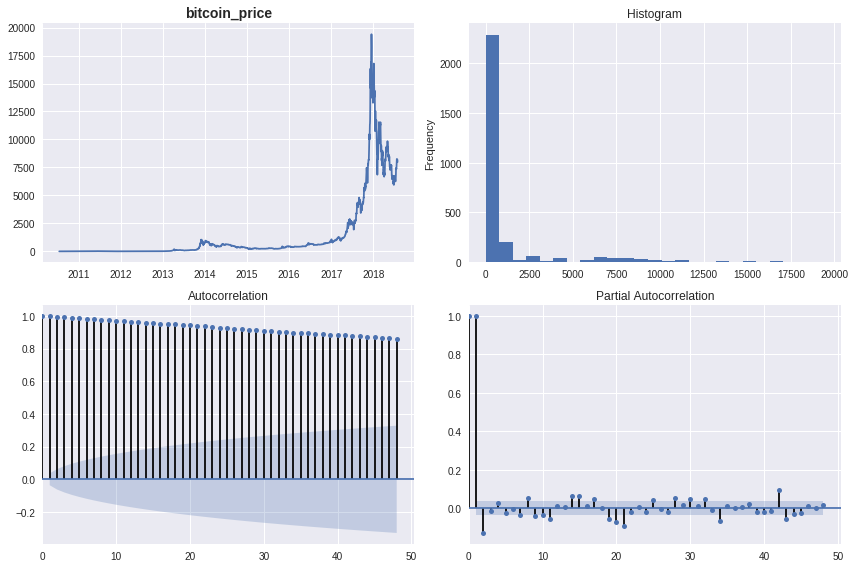

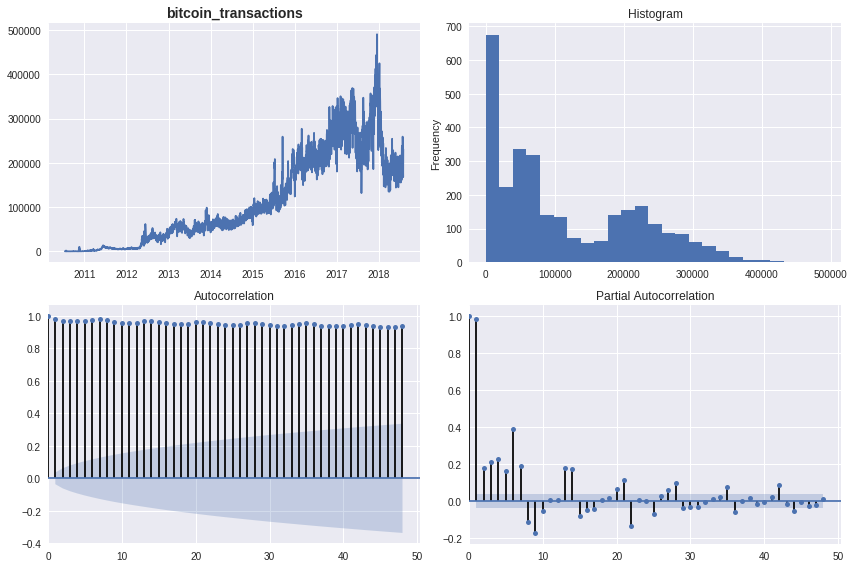

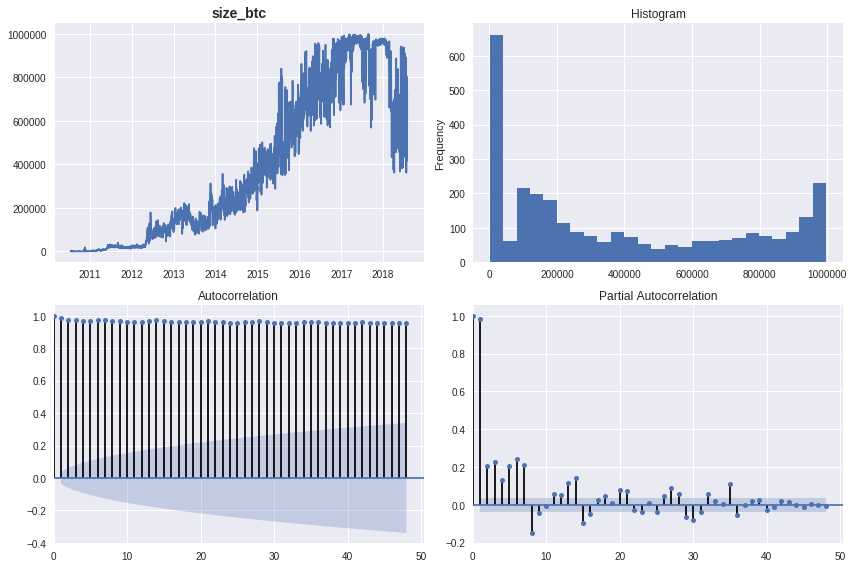

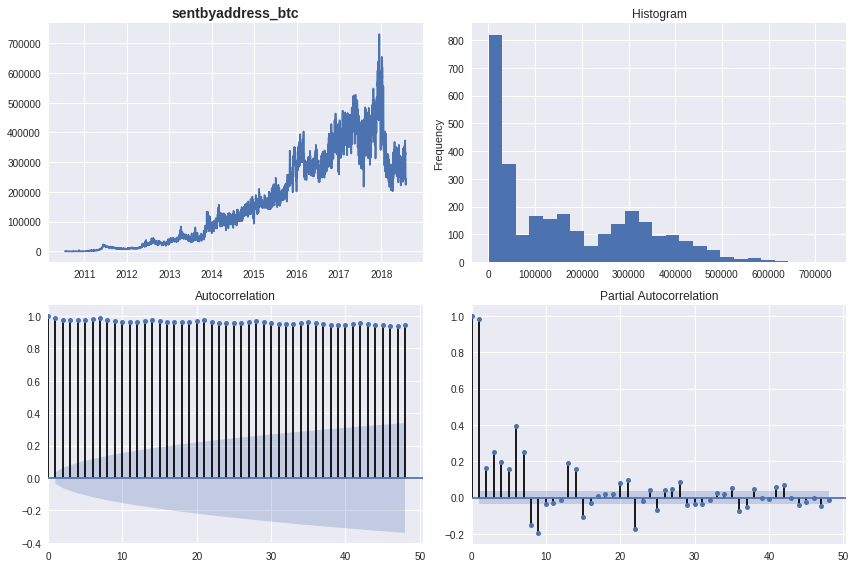

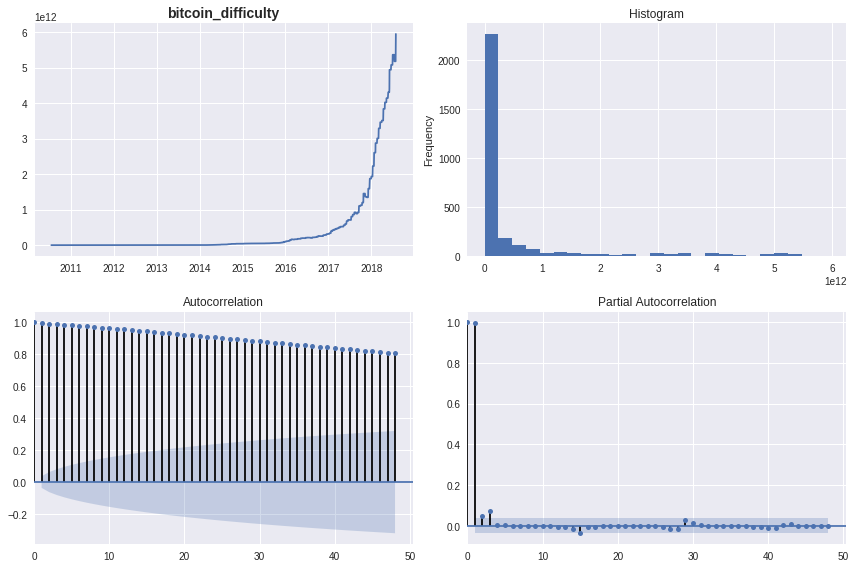

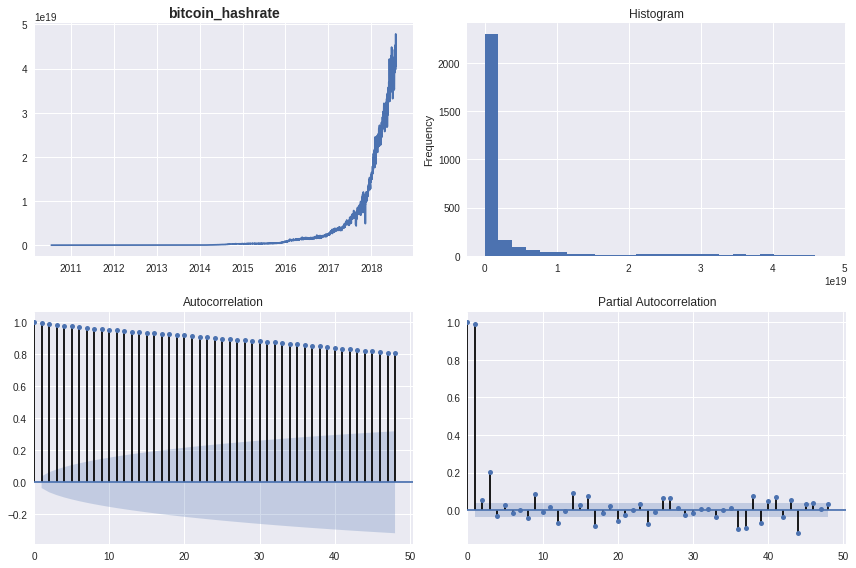

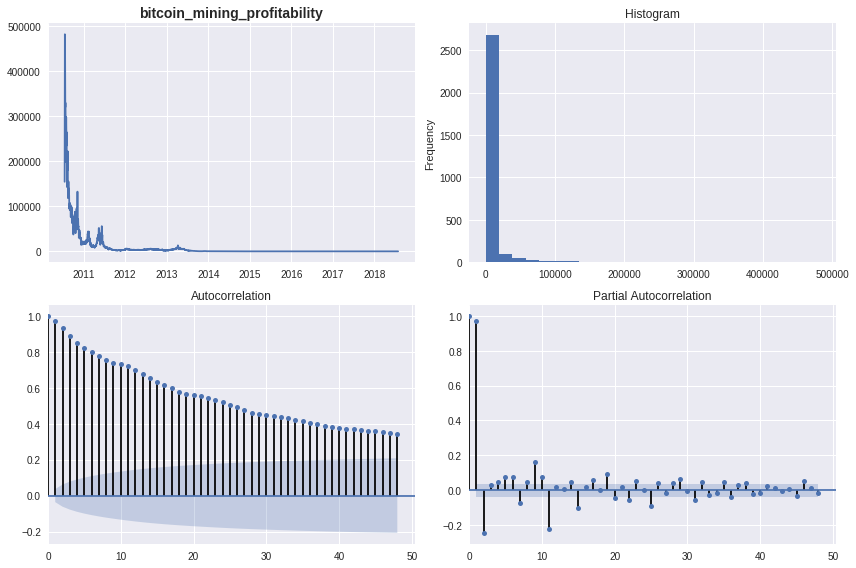

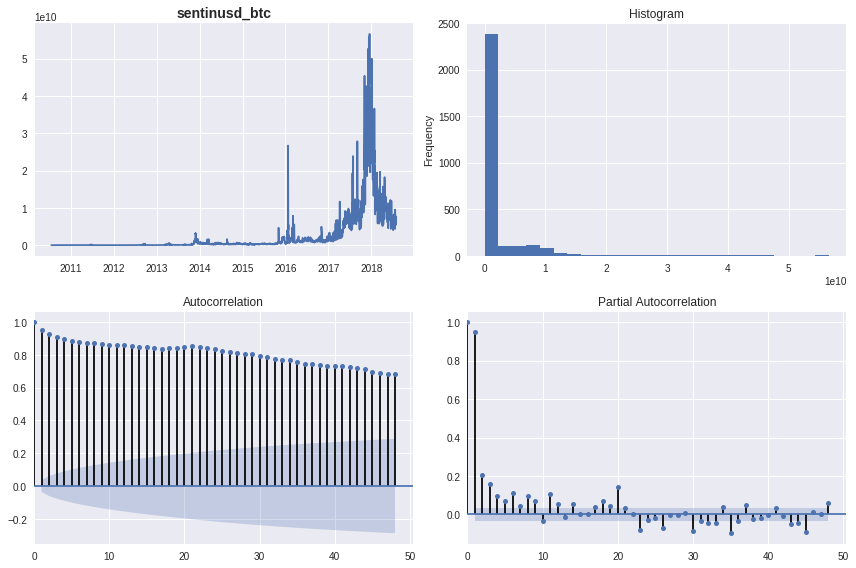

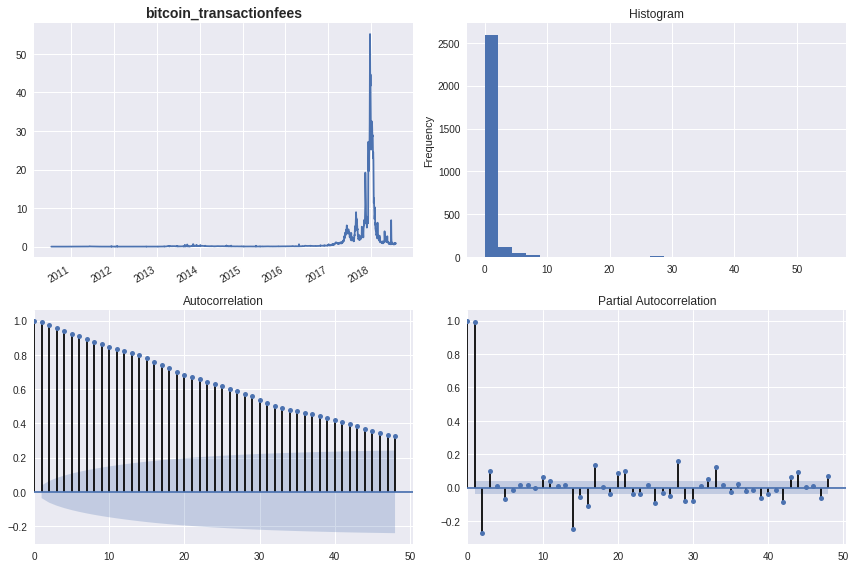

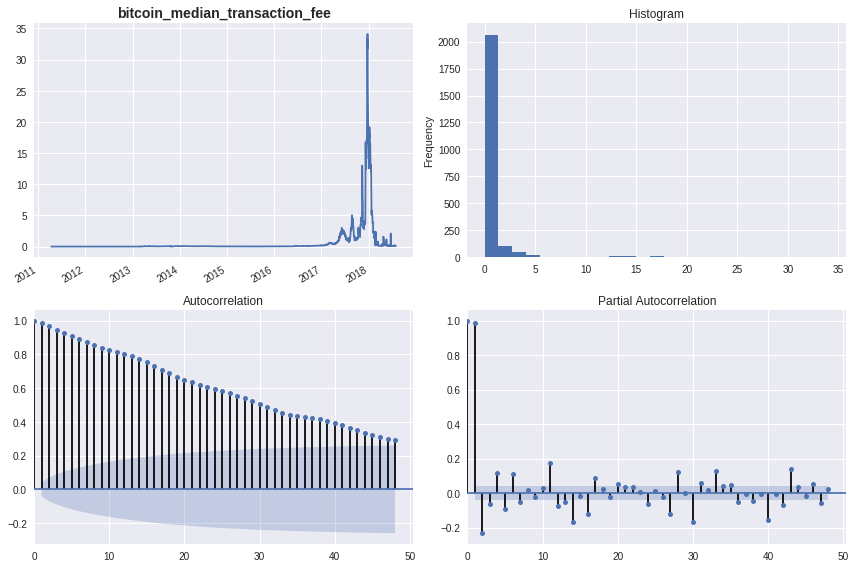

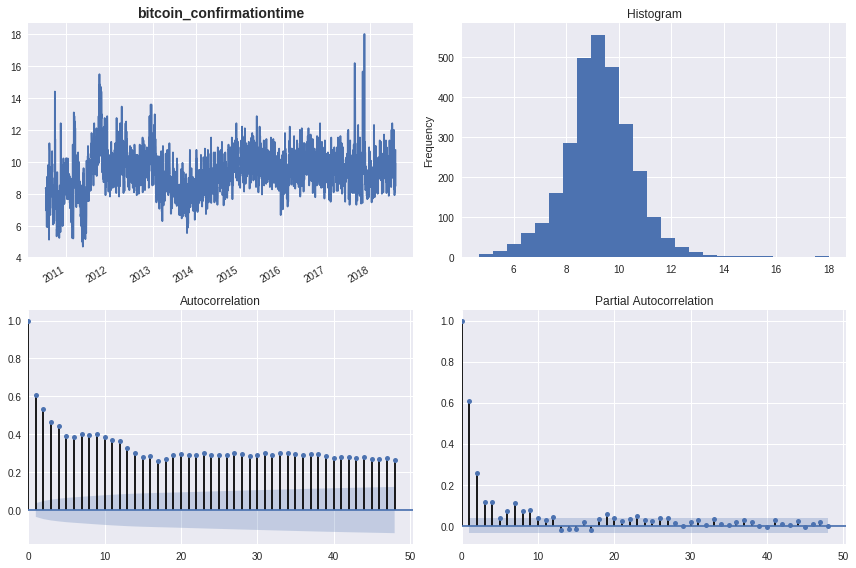

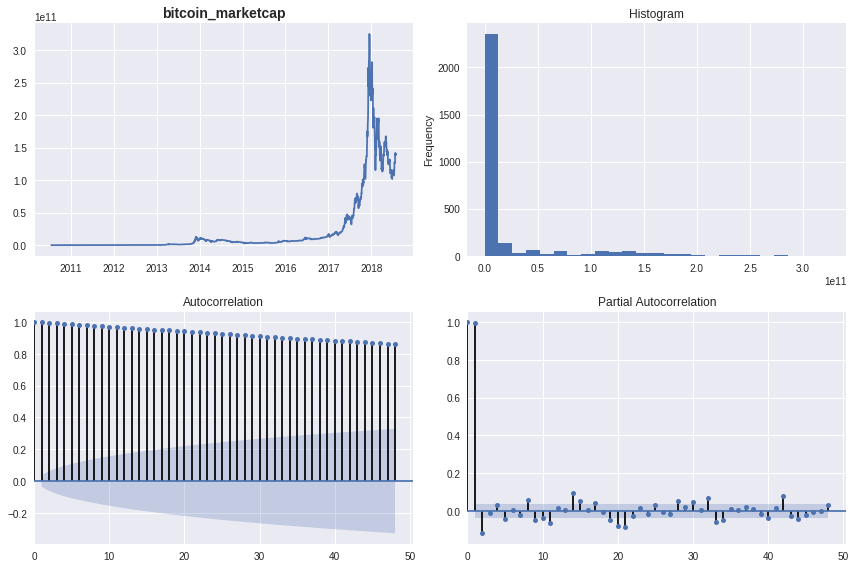

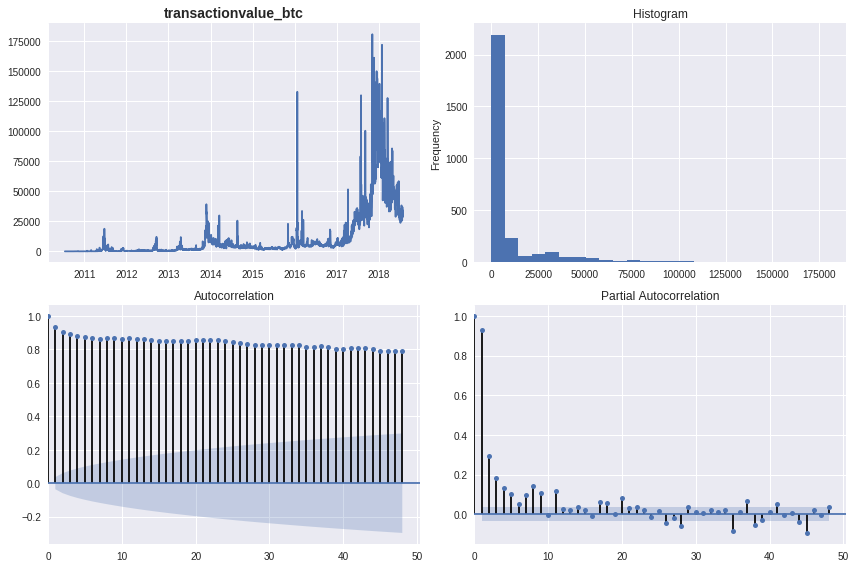

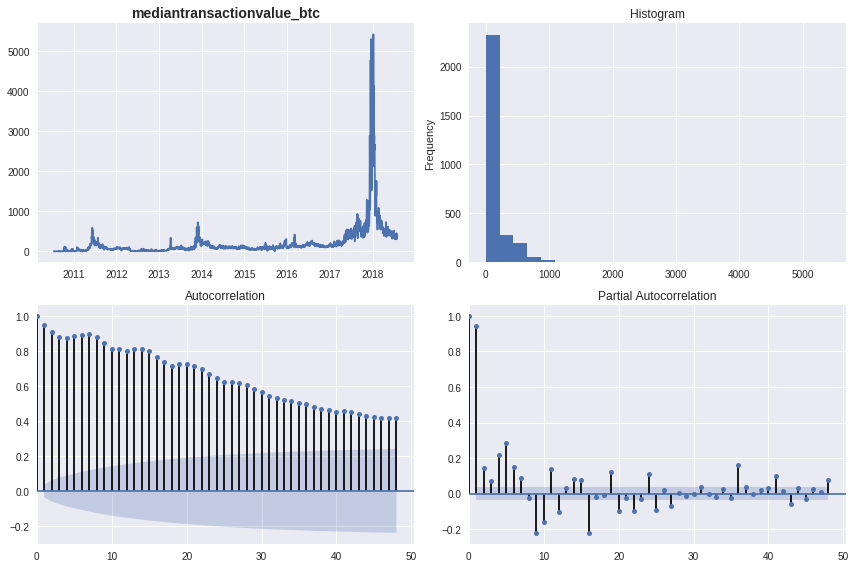

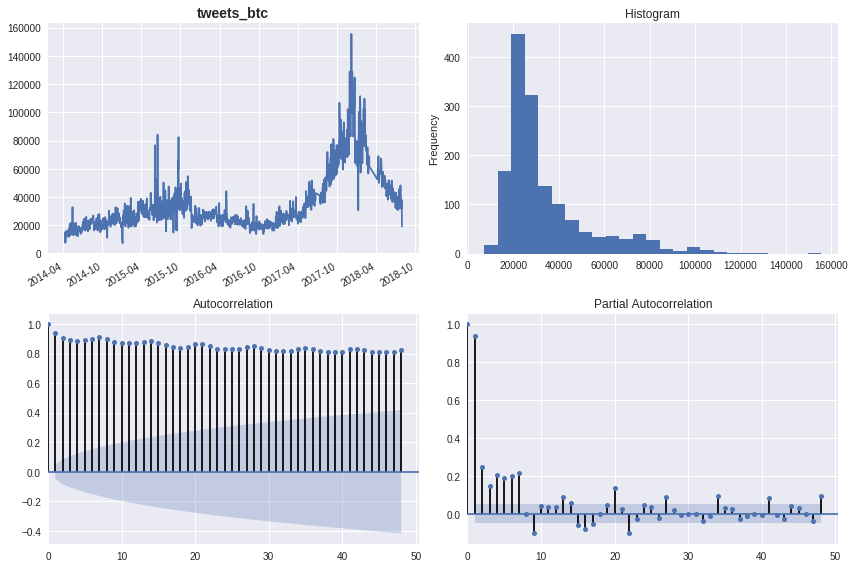

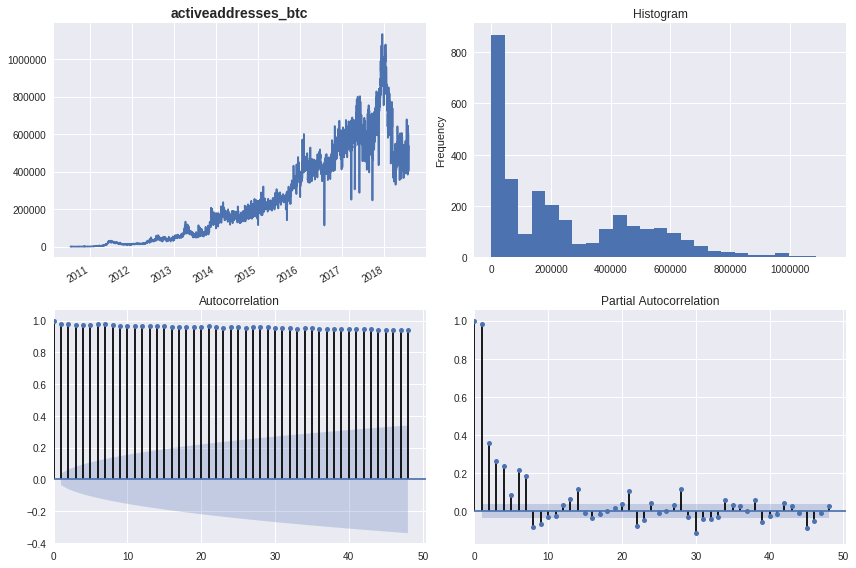

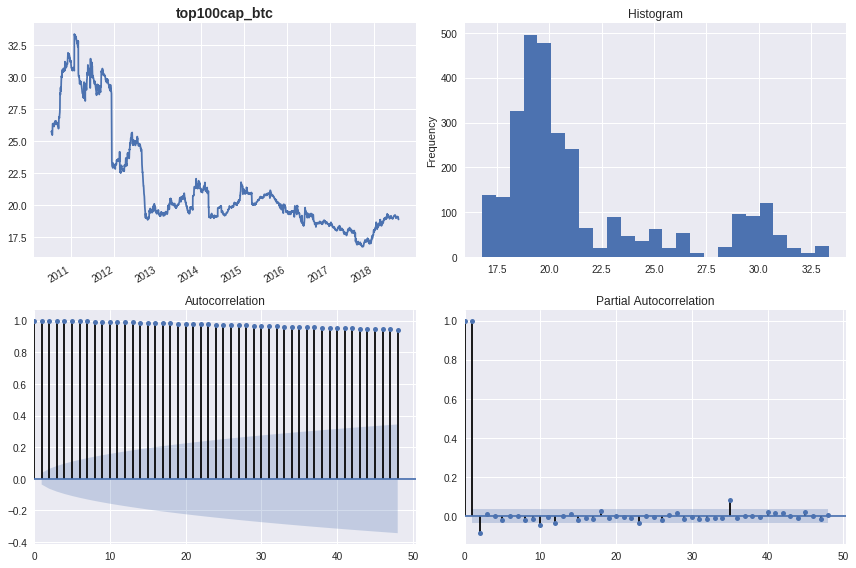

In [0]:
num_var = len(df.iloc[1,:])
for i in range(0, num_var):
    plotter(df.iloc[:,i].dropna(), title=df.columns[i], lags=48)

From the visualization of our data, we come to a couple of conclusions. First of all we can see that most of the series is autocorrelated, and we will have to make the series stationary. Second, is that some of the columns will not be useful in terms of explaining the price of Bitcoin over time, as their values don't change over time (mining profitability(may also be the result of price going up or down) or confirmation time) and some contain NaN values. For simplicity we decide to drop these columns. Below we take a look at which rows contain NaN values in any of the columns.

In [0]:
df[df.isnull().any(axis=1)]

,bitcoin_price,bitcoin_transactions,size_btc,sentbyaddress_btc,bitcoin_difficulty,bitcoin_hashrate,bitcoin_mining_profitability,sentinusd_btc,bitcoin_transactionfees,bitcoin_median_transaction_fee,bitcoin_confirmationtime,bitcoin_marketcap,transactionvalue_btc,mediantransactionvalue_btc,tweets_btc,activeaddresses_btc,top100cap_btc
2010-07-17,0.0495,235.0,649.653015,390.0,1.815430e+02,2.775561e+09,154298.000,1.193000e+03,0.000010,NaN,8.324,1.698390e+05,2.924000,0.248000,NaN,804.0,25.749001
2010-07-18,0.0726,248.0,765.284973,424.0,1.815430e+02,1.554461e+09,401834.000,2.620000e+03,0.000243,NaN,8.372,2.497610e+05,6.237000,0.363000,NaN,917.0,25.782000
2010-07-19,0.0859,354.0,756.039978,553.0,1.815430e+02,1.551288e+09,481473.000,4.048000e+03,0.000022,NaN,8.276,2.959810e+05,7.666000,0.429000,NaN,972.0,25.684999
2010-07-20,0.0783,413.0,984.706970,632.0,1.815430e+02,1.640430e+09,431831.000,2.341000e+03,NaN,NaN,7.956,2.705460e+05,3.940000,5.105000,NaN,906.0,25.601999
2010-07-21,0.0767,256.0,542.482971,440.0,1.815430e+02,1.723493e+09,460783.000,2.122000e+03,NaN,NaN,6.957,2.659000e+05,4.583000,3.837000,NaN,809.0,25.638000
2010-07-22,0.0649,221.0,491.903015,412.0,1.815430e+02,1.705481e+09,334641.000,2.570000e+03,NaN,NaN,8.182,2.254200e+05,6.474000,1.054000,NaN,599.0,25.604000
2010-07-23,0.0566,217.0,447.160004,405.0,1.815430e+02,1.716129e+09,319692.000,1.166000e+03,0.000003,NaN,7.423,1.970860e+05,2.837000,0.814000,NaN,652.0,25.509001
2010-07-24,0.0581,705.0,1446.000000,645.0,1.815430e+02,1.665066e+09,329602.000,2.540000e+03,NaN,NaN,7.619,2.029290e+05,2.842000,0.445000,NaN,964.0,25.527000
2010-07-25,0.0530,1592.0,3145.000000,1793.0,1.815430e+02,1.907548e+09,320839.000,2.493000e+03,0.000096,NaN,6.234,1.856090e+05,1.368000,0.458000,NaN,2132.0,25.504999
2010-07-26,0.0530,224.0,918.379028,408.0,1.815430e+02,2.223656e+09,289627.000,4.608000e+03,0.000357,NaN,5.926,1.863080e+05,9.868000,2.650000,NaN,1238.0,26.309000


In [0]:
df = df.drop(['bitcoin_mining_profitability','bitcoin_median_transaction_fee', 'tweets_btc', 'bitcoin_transactionfees', 'activeaddresses_btc', 'bitcoin_confirmationtime', 'top100cap_btc'], axis=1)

In [0]:
df = df.drop(df.index[len(df)-1])

In [0]:
df[df.isnull().any(axis=1)]

,bitcoin_price,bitcoin_transactions,size_btc,sentbyaddress_btc,bitcoin_difficulty,bitcoin_hashrate,sentinusd_btc,bitcoin_marketcap,transactionvalue_btc,mediantransactionvalue_btc


# VARMAX model

We have now got rid of obsolete columns, and all the NaN values. Our data is clean and ready to be further processed. For VARMAX model we have to make the series stationary by taking first log difference. For our Recurrent Neural Network we will convert our series to be in range from 0 to 1 as that is how the network does best with the data fed.

In [0]:
df_transformed = df.copy()

We take a log of each value in each column and take one day difference to end up with daily logarithmic returns.

In [0]:
num = len(df.iloc[1,:])
for i in range(0, num):
    df_transformed.iloc[:,i] = np.log(df_transformed.iloc[:,i]).diff(1)

In [0]:
df_transformed

,bitcoin_price,bitcoin_transactions,size_btc,sentbyaddress_btc,bitcoin_difficulty,bitcoin_hashrate,sentinusd_btc,bitcoin_marketcap,transactionvalue_btc,mediantransactionvalue_btc
2010-07-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-18,0.382992,0.053843,0.163810,0.083587,0.000000,-0.579724,0.786703,0.385654,0.757547,0.380974
2010-07-19,0.168219,0.355868,-0.012154,0.265625,0.000000,-0.002044,0.435049,0.169791,0.206296,0.167054
2010-07-20,-0.092636,0.154151,0.264250,0.133531,0.000000,0.055873,-0.547645,-0.089853,-0.665614,2.476519
2010-07-21,-0.020646,-0.478270,-0.596187,-0.362115,0.000000,0.049394,-0.098219,-0.017322,0.151173,-0.285530
2010-07-22,-0.167054,-0.147015,-0.097875,-0.065751,0.000000,-0.010506,0.191547,-0.165155,0.345440,-1.292098
2010-07-23,-0.136839,-0.018265,-0.095365,-0.017136,0.000000,0.006224,-0.790327,-0.134325,-0.825047,-0.258387
2010-07-24,0.026157,1.178300,1.173640,0.465363,0.000000,-0.030206,0.778585,0.029216,0.001761,-0.603886
2010-07-25,-0.091874,0.814549,0.777013,1.022395,0.000000,0.135954,-0.018677,-0.089214,-0.731158,0.028795
2010-07-26,0.000000,-1.961100,-1.230959,-1.480378,0.000000,0.153334,0.614307,0.003759,1.975947,1.755446


In [0]:
df_transformed = df_transformed.drop(df.index[:1])

We got rid of the first row which contained NaNs because of us taking the log difference. Now we will conduct the Augmented Dickey-Fuller unit root test on both our dataframes: the original, and the transformed to see if we succeded in making all the series stationary. The null-hypothesis of this test is that a unit root is present. We can assume that if we obtain p-value of less than 0,05 that means that we are good to go further with the VARMAX model calculation.

In [0]:
from statsmodels.tsa.stattools import adfuller

In [0]:
for i in range(0, num):
    s1=df.iloc[:,i]
    s2= df_transformed.iloc[:,i]
    result1 = adfuller(s1)
    result2 = adfuller(s2)
    print('Not transformed: ', df.columns[i])
    print(result1)
    print('ADF Statistic: %f' % result1[0])
    print('p-value: %f' % result1[1])
    print('Critical Values:')
    for key, value in result1[4].items():
        print('\t%s: %.3f' % (key, value))
    print('Transformed: ', df_transformed.columns[i])
    print(result2)
    print('ADF Statistic: %f' % result2[0])
    print('p-value: %f' % result2[1])
    print('Critical Values:')
    for key, value in result2[4].items():
        print('\t%s: %.3f' % (key, value))
    print("\n")

Not transformed:  bitcoin_price
(-1.4086004705880997, 0.5781460701522845, 27, 2908, {'1%': -3.4326007158683978, '5%': -2.862534415652797, '10%': -2.567299355555703}, 37451.77320269689)
ADF Statistic: -1.408600
p-value: 0.578146
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Transformed:  bitcoin_price
(-11.758174253611623, 1.1650413972843352e-21, 13, 2921, {'1%': -3.43259069016496, '5%': -2.8625299877426853, '10%': -2.5672969981708205}, -10480.519462751574)
ADF Statistic: -11.758174
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Not transformed:  bitcoin_transactions
(-1.113509363273767, 0.7096545692791769, 28, 2907, {'1%': -3.4326014907937523, '5%': -2.8625347579024583, '10%': -2.567299537766863}, 64040.26124953933)
ADF Statistic: -1.113509
p-value: 0.709655
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Transformed:  bitcoin_transactions
(-14.879749288845614, 1.6161234207234703e-27, 27, 2907, {'1%': -3.4326014907937523, '5%': -2.86253475790245

As we can see almost all of the non-transformed series contained a unit root, but the transformed series generate p-values close to 0, so we can reject the null hypothesis and continue.

In [0]:
from statsmodels.tsa.api import VARMAX

We will split the data into a training and testing sets. We will train the VARMAX model on the training set, and test its results on the test set. We will be using the same split for the VARMAX model, as well as the RNN deep learning model.

In [0]:
df.shape

(2936, 10)

Our original dataframe contains 2936 observations. Our test set will contain the last 440 observations (from 2017-05-17). And the training set, all the remaining data.

In [0]:
df_transformed.iloc[:-440]

,bitcoin_price,bitcoin_transactions,size_btc,sentbyaddress_btc,bitcoin_difficulty,bitcoin_hashrate,sentinusd_btc,bitcoin_marketcap,transactionvalue_btc,mediantransactionvalue_btc
2010-07-18,0.382992,0.053843,0.163810,0.083587,0.000000,-0.579724,0.786703,0.385654,0.757547,0.380974
2010-07-19,0.168219,0.355868,-0.012154,0.265625,0.000000,-0.002044,0.435049,0.169791,0.206296,0.167054
2010-07-20,-0.092636,0.154151,0.264250,0.133531,0.000000,0.055873,-0.547645,-0.089853,-0.665614,2.476519
2010-07-21,-0.020646,-0.478270,-0.596187,-0.362115,0.000000,0.049394,-0.098219,-0.017322,0.151173,-0.285530
2010-07-22,-0.167054,-0.147015,-0.097875,-0.065751,0.000000,-0.010506,0.191547,-0.165155,0.345440,-1.292098
2010-07-23,-0.136839,-0.018265,-0.095365,-0.017136,0.000000,0.006224,-0.790327,-0.134325,-0.825047,-0.258387
2010-07-24,0.026157,1.178300,1.173640,0.465363,0.000000,-0.030206,0.778585,0.029216,0.001761,-0.603886
2010-07-25,-0.091874,0.814549,0.777013,1.022395,0.000000,0.135954,-0.018677,-0.089214,-0.731158,0.028795
2010-07-26,0.000000,-1.961100,-1.230959,-1.480378,0.000000,0.153334,0.614307,0.003759,1.975947,1.755446
2010-07-27,0.090151,0.149036,-0.301590,0.026604,0.276246,0.087398,-0.912608,0.093602,-0.820732,-2.609315


In [0]:
train, test = df_transformed[:-440], df_transformed.iloc[-440:]

We can set up a loop which will help us choose the best lag order for our model, based on criteria of AIC, BIC and HQIC, the lower, the better.

In [0]:
for i in range(5):
    i+=1
    model = VARMAX(y_train, order=(i,0))
    model_result = model.fit(maxiter = 1000, disp=False)
    print('Order = ', i)
    print('AIC: ', model_result.aic)
    print('BIC: ', model_result.aic)
    print('HQIC: ', model_result.hqic)

We choose the lag order of 3, which means that our model will calculate parameters for all the features in our model for lag order of 1, 2 and 3.

In [0]:
var_model = VARMAX(train, order=(3,0))
var_model_result = var_model.fit(maxiter = 1000, disp=False)
print(var_model_result.summary())

C:\Users\piotr\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                                                                                                          Statespace Model Results                                                                                                                          
Dep. Variable:     ['bitcoin_price', 'bitcoin_transactions', 'size_btc', 'sentbyaddress_btc', 'bitcoin_difficulty', 'bitcoin_hashrate', 'sentinusd_btc', 'bitcoin_marketcap', 'transactionvalue_btc', 'mediantransactionvalue_btc']   No. Observations:                 2495
Model:                                                                                                                                                                                                                       VAR(3)   Log Likelihood               28472.075
                                                                                                                                                                                                 

No let's visualize our results.

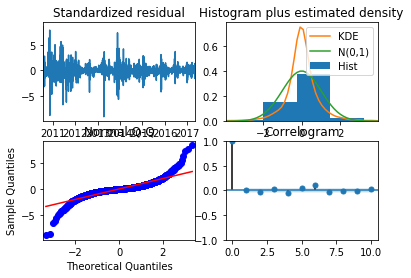

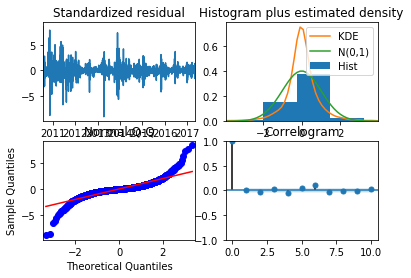

In [0]:
var_model_result.plot_diagnostics()

In [0]:
#var_model_result.save('var_model_1')

In order to get the predictions, we have to update the dataset by joining the last 3 observations from the training set (we used 3 lags in our model) and the test set. Then we set up a 'new' model that uses the parameters of the original model. 

In [0]:
kwargs = {'order': (3,0), 'trend':'c'}
update = pd.concat([train.iloc[-3:], test])
model = VARMAX(update, **kwargs)
model.initialize_known(var_model_result.predicted_state[:, -2], var_model_result.predicted_state_cov[:, :, -2])
res = model.smooth(var_model_result.params)

C:\Users\piotr\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [0]:
Now our model can make predictions based on the test set.

In [0]:
pred = np.exp(res.predict())*df['2017-05-13':].shift(1)

In [0]:
true = df.bitcoin_price['2017-05-14':]

Let's make comparison of the true price of Bitcoin vs the price predicted by the model.

In [0]:
compare = pd.concat([true, pred['bitcoin_price']], axis=1).dropna()

In [0]:
compare.columns = ['BTC_Price_true', 'BTC_Price_predicted']

In [0]:
compare

,BTC_Price_true,BTC_Price_predicted
2017-05-14,1776.0,1653.827262
2017-05-15,1722.0,1845.610658
2017-05-16,1709.0,1678.790020
2017-05-17,1790.0,1734.482898
2017-05-18,1837.0,1829.265246
2017-05-19,1923.0,1836.085908
2017-05-20,1988.0,1958.831272
2017-05-21,2045.0,2003.774449
2017-05-22,2149.0,2067.855895
2017-05-23,2208.0,2194.200757


The values predicted seem to be close to the true values. Let's plot our results on a graph. We set the period from 2018-06-01 to 2018-07-30 to be able to look closely on how well our model does.

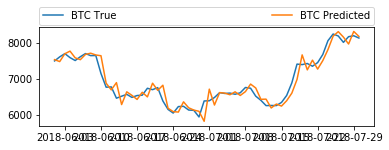

In [0]:
plt.subplot(211)
plt.plot(compare['BTC_Price_true']['2018-06-01':'2018-07-30'], label='BTC True')
plt.plot(compare.iloc[:,1:]['2018-06-01':'2018-07-30'], label = 'BTC Predicted')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

As we can see, our model does pretty well in predicting the price, but seem to have a lag. We have to remember that we set only one day prediction range, and the lag seems to be of about one day, so in trading practice this model would not be very helpful. We have to set a metric to compare these results to the results obraining through training the Neural Network, so we will use the root-mean-square-error (RMSE).

In [0]:
from math import sqrt
from sklearn.metrics import mean_squared_error

In [0]:
rmse = sqrt(mean_squared_error(y_true=true, y_pred=pred['bitcoin_price'].dropna()))

In [0]:
rmse

442.58751244992374

In [0]:
#from statsmodels.tsa.statespace.varmax import VARMAXResults

In [0]:
#new_res = VARMAXResults.load('var_model')

The root-mean-squared-error obtained through our VARMAX model is 442.59, which seems very big and using such model for predicting the next day's price of Bitcoin  would be very risky and unreliable. 
<br>
<br> We have now set a benchmark for our Recurrent Neural Network and we have to find out if our model could beat the VARMAX model in terms of the RMSE

# Recurrent Neural Network
For our steps in setting up a Neural Net we have to make sure that our data is fine. If yes, than we are going to proceed with data preparation

In [0]:
df[df.isnull().any(axis=1)]

,bitcoin_price,bitcoin_transactions,size_btc,sentbyaddress_btc,bitcoin_difficulty,bitcoin_hashrate,sentinusd_btc,bitcoin_marketcap,transactionvalue_btc,mediantransactionvalue_btc


We set the target of our future prediction.

In [0]:
target = 'bitcoin_price'

As well as in our VARMAX model we want our RNN model to predict one day into the future so we se the shift step of 1. We end up with the prices of Bitcoin shifted one day back. This price will correspond to remaining data from previous day and thus enabling our model to predict one day ahead.

In [0]:
shift_steps = 1

In [0]:
df_target = df[target].shift(-shift_steps)

In [0]:
df_target.head()

2010-07-17    0.0726
2010-07-18    0.0859
2010-07-19    0.0783
2010-07-20    0.0767
2010-07-21    0.0649
Freq: D, Name: bitcoin_price, dtype: float64

In [0]:
df_target.tail()

2018-07-26    8021.0
2018-07-27    8180.0
2018-07-28    8206.0
2018-07-29    8142.0
2018-07-30       NaN
Freq: D, Name: bitcoin_price, dtype: float64

Now we set the data variables. `y_data` is our target values, and `x_data` correspond to our explaining features.

In [0]:
y_data = df_target.values[:-shift_steps]

In [0]:
y_data.shape

(2935,)

In [0]:
x_data = df.iloc[:,1:].values[0:-shift_steps]

In [0]:
x_data.shape

(2935, 9)

We have 2935 observations, and 9 features are there to predict the 1-day ahead value of *bitcoin_price*.

We choose the same split for the RNN as for the VARMAX model.

In [0]:
x_train = x_data[:-440]
x_test = x_data[-440:]

In [0]:
y_train = y_data[:-440]
y_test = y_data[-440:]

In [0]:
y_test.shape

(440,)

In [0]:
num_train = len(x_train)

In [0]:
num_x_signals = x_data.shape[1]

In [0]:
num_y_signals = 1

We have succesfully split our data. We also set the number of signals which we will use later to indicate the expected shapes to our neural net. Now we move on to scaling the data.

# Data scaling
We will use the `MinMaxScaler` from the scikit-learn module to scale the dataframe to values from 0 to 1. We have to remember that we scale the train set and test set separately. If we did otherwise it would be cheating, because that would mean our model knows future values, and we do not want to do that. We also use separate scaler objects for `x_data` and `y_data`.

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
x_scaler = MinMaxScaler()

In [0]:
x_train_scaled = x_scaler.fit_transform(x_train)

In [0]:
x_test_scaled = x_scaler.transform(x_test)

In [0]:
y_scaler = MinMaxScaler()

In [0]:
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1))

In [0]:
y_test_scaled = y_scaler.transform(y_test.reshape(-1,1))

In [0]:
x_train_scaled.shape

(2495, 9)

In [0]:
y_test_scaled.shape

(440, 1)

# Batch generator
We could be training our model on the whole training data, but that would be very demanding for our GPU, so instead we will split the training set into batches and feed these small batches into our network. This way the training is faster and more effective. We construct a helper function that takes `batch_size` and `sequence_length` arguments. The sequence_length is number of rows of data taken into a batch and the batch_size is the size of the batch.

In [0]:
def batch_generator(batch_size, sequence_length):
    while True:
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        for i in range(batch_size):
            idx = np.random.randint(num_train - sequence_length)
            
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

Now we can actually set the size of a single batch and the length of sequence fed to the neural network.

In [0]:
batch_size = 10

In [0]:
sequence_length = 16

In [0]:
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

We can set validation data which will be used to evaluate the loss and model metrics at the end of each epoch of training. What is important - this data will not be used for training. We also set some callback functions that will be used during our training. First of all, the measure we will focus the most on is the `val_loss` - the loss obtained on the `validation_data`, as we want the best fit for our test set. The `callback_checpoint` function will save the weights of the model every time it reaches a better `val_loss` measure. We will also use the `early_stopping` function which will focues also on the validation set loss, and if it is not improved after 5 consecutive epochs it will end the training. We also set a `reduce_learning_rate` function which will decrease the learning rate when a plateau is reached.

In [0]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [0]:
path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [0]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [0]:
callback_tensorboard = TensorBoard(log_dir='./logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [0]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [0]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

# Hyperparameters
Choosing the right hyperparameters for our training can be hard to achieve, as there are so many factors to tak into consideration. There is a library called `scikit-optimize` which can help in choosing the right parameters for our training. This library was introduced to me by Magnus Petersen and we will use this method to choose the best parameters for the training.

In [0]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

In [0]:
#!pip install -q scikit-optimize

We want to set the following 3 hyperparameters: number of RNN layers, number of RNN nodes in each layer, and the activation function for our GRU cells.

In [0]:
dim_num_rnn_layers = Integer(low=1, high=5, name='num_rnn_layers')
dim_num_rnn_nodes = Integer(low=5, high=512, name='num_rnn_nodes')
dim_activation = Categorical(categories=['relu', 'sigmoid', 'linear', 'tanh'], name='activation')

In [0]:
dimensions = [dim_num_rnn_layers, dim_num_rnn_nodes, dim_activation]
default_parameters = [2, 512, 'relu']

In [0]:
def log_dir_name(num_rnn_layers, num_rnn_nodes, activation):

    s = "./logs/layers_{0}_nodes_{1}_{2}/"

    log_dir = s.format(num_rnn_layers,
                       num_rnn_nodes,
                       activation)

    return log_dir

In [0]:
from tensorflow.python.keras import backend as K

We create a function that creates the model. For our initial layer we choose the Gated Reccurent Unit with number of nodes set to 512. The second layer is also GRU, but we want the `scikit-optimize` decide which activation function to use, and how many nodes in this layer. Next we set a for loop which will be used to add layers according to the optimizing algorithm. The last layer is a dense layer with one node (as we only want to predict one feature) and a linear activation function. In time series problems we have to remember to set the activation of the last dense layer to be linear, otherwise our model will not be able to predict values higher than the inputs (which in our case are from 0 to 1). 

In [0]:
def create_model(num_rnn_layers, num_rnn_nodes, activation):

    model = Sequential()

    model.add(GRU(units=512, return_sequences=True, input_shape=(None, num_x_signals,)))
    
    model.add(GRU(units = num_rnn_nodes, return_sequences=True, activation=activation, name='layer_rnn1'))

    for i in range(num_rnn_layers):
        name = 'layer_rnn_{0}'.format(i+1)

        model.add(GRU(num_rnn_nodes, return_sequences=True, activation=activation, name=name))

    model.add(Dense(num_y_signals, activation='linear'))
    
    optimizer = Adam(lr=0.001)
    
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mse', 'mae'])
    
    return model

In [0]:
path_best_model = '11_best_model.keras'
best_mse = 0.0
best_mae = 0.0

In [0]:
@use_named_args(dimensions=dimensions)
def fitness(num_rnn_layers,num_rnn_nodes, activation):

    print('num_rnn_layers:', num_rnn_layers)
    print('num_rnn_nodes:', num_rnn_nodes)
    print('activation:', activation)
    print()
    
    model = create_model(num_rnn_layers=num_rnn_layers,
                         num_rnn_nodes=num_rnn_nodes,
                         activation=activation)

    log_dir = log_dir_name(num_rnn_layers,
                           num_rnn_nodes, activation)
    
    callback_log = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        batch_size=32,
        write_graph=True,
        write_grads=False,
        write_images=False)
   
    history = model.fit_generator(generator=generator, epochs=3, steps_per_epoch=100, validation_data=validation_data)

    mse = history.history['mean_squared_error'][-1]
    mae = history.history['mean_absolute_error'][-1]
    print()
    print("MSE: {0:.2%}".format(mse))
    print("MAE: {0:.2%}".format(mae))
    print()
    print(history.history['mean_squared_error'])
    print(history.history['mean_absolute_error'])
    
    global best_mse
    global best_mae

    if mse > best_mse:
        model.save(path_best_model)
        
        best_mse = mse

    del model

    K.clear_session()

    return mse

In [0]:
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=11,
                            x0=default_parameters)

num_rnn_layers: 2
num_rnn_nodes: 512
activation: relu

Epoch 1/3
100/100 [==============================] - 25s 253ms/step - loss: 5415227.8013 - mean_squared_error: 5415227.8013 - mean_absolute_error: 46.7165 - val_loss: 29741.8418 - val_mean_squared_error: 29741.8418 - val_mean_absolute_error: 171.7933
Epoch 2/3
100/100 [==============================] - 17s 169ms/step - loss: 542.4634 - mean_squared_error: 542.4634 - mean_absolute_error: 8.6510 - val_loss: 26.0095 - val_mean_squared_error: 26.0095 - val_mean_absolute_error: 4.6453
Epoch 3/3
 51/100 [==============>...............] - ETA: 7s - loss: 0.3082 - mean_squared_error: 0.3082 - mean_absolute_error: 0.3877100/100 [==============================] - 17s 169ms/step - loss: 0.2098 - mean_squared_error: 0.2098 - mean_absolute_error: 0.3028 - val_loss: 19.3912 - val_mean_squared_error: 19.3912 - val_mean_absolute_error: 3.8659

MSE: 20.98%
MAE: 30.28%

[5415227.80126271, 542.4634278714657, 0.20976275291293858]
[46.71654012918472, 8

 66/100 [==================>...........] - ETA: 10s - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0774100/100 [==============================] - 29s 285ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0621 - val_loss: 0.7277 - val_mean_squared_error: 0.7277 - val_mean_absolute_error: 0.6089
Epoch 2/3
100/100 [==============================] - 20s 204ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0227 - val_loss: 0.8978 - val_mean_squared_error: 0.8978 - val_mean_absolute_error: 0.5665
Epoch 3/3
100/100 [==============================] - 20s 204ms/step - loss: 5.9643e-04 - mean_squared_error: 5.9643e-04 - mean_absolute_error: 0.0142 - val_loss: 1.0761 - val_mean_squared_error: 1.0761 - val_mean_absolute_error: 0.7513

MSE: 0.06%
MAE: 1.42%

[0.010739020571345464, 0.001658032602572348, 0.0005964259932079585]
[0.062107067815959455, 0.02270738309249282, 0.014158044075593353]
num_rnn_layers: 1
num_rnn_nodes: 39

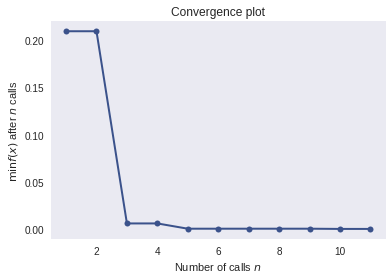

In [0]:
plot_convergence(search_result)

After letting `scikit learn` to search for the best combination of hyperparameters we get to see that it managed to improve quite considerably on third iteration. We can see the best combination:

In [0]:
search_result.x

[1, 393, 'tanh']

In [0]:
hypers_list = ['num_rnn_layers', 'num_rnn_nodes', 'activation']

In [0]:
hyp_res = {x:y for x,y in zip(hypers_list, search_result.x)}

In [0]:
hyp_res

{'activation': 'tanh', 'num_rnn_layers': 1, 'num_rnn_nodes': 393}

Now we set our final model to train on the data. We choose two hidden recurrent layers with GRU cels with 401 nodes, and 'relu' activation functions.

In [0]:
model = Sequential()

model.add(GRU(units=512, return_sequences=True, input_shape=(None, num_x_signals,)))
    
model.add(GRU(units = 401, return_sequences=True, activation='relu', name='layer_rnn1'))

model.add(GRU(units = 401, return_sequences=True, activation='relu', name='layer_rnn2'))

#model.add(GRU(units = 401, return_sequences=True, activation='relu', name='layer_rnn3'))

model.add(Dense(num_y_signals, activation='relu'))
    
optimizer = Adam(lr=0.001)
    
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', 'mae'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, None, 512)         801792    
_________________________________________________________________
layer_rnn1 (GRU)             (None, None, 401)         1099542   
_________________________________________________________________
layer_rnn2 (GRU)             (None, None, 401)         966009    
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           402       
Total params: 2,867,745
Trainable params: 2,867,745
Non-trainable params: 0
_________________________________________________________________


Now it is time for training the model. Our model will be fed with batches of data from our batch generator function. We set 20 epochs of learning, with 200 steps per epoch. The validation data are our test sets, and we pass the list of callback functions, previously set.

In [0]:
%%time
model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=200,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/20
199/200 [============================>.] - ETA: 0s - loss: 0.0380 - mean_squared_error: 0.0380 - mean_absolute_error: 0.0735
Epoch 00001: val_loss improved from 14.60406 to 0.66909, saving model to checkpoint.keras
200/200 [==============================] - 30s 149ms/step - loss: 0.0378 - mean_squared_error: 0.0378 - mean_absolute_error: 0.0733 - val_loss: 0.6691 - val_mean_squared_error: 0.6691 - val_mean_absolute_error: 0.6183
Epoch 2/20
124/200 [=================>............] - ETA: 8s - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0263199/200 [============================>.] - ETA: 0s - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0242
Epoch 00002: val_loss did not improve from 0.66909

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
200/200 [==============================] - 24s 122ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0242 - val_loss: 0.6696 - val_mean_s

The model trained succesfully. All our callback functions were used. We saved our best performing on the validation set data as a checkpoint. The training was stopped early because it did not achieve improvement over five epochs. The best `val_loss` achieved was 0.44.

In [0]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [0]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 1s 846ms/step


In [0]:
for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

loss: 4.409e-01
mean_squared_error: 4.409e-01
mean_absolute_error: 4.039e-01


With our best performing checpoint loaded we make a prediction on our `x_test` set.

In [0]:
y_pred = model.predict(np.expand_dims(x_test_scaled, axis=0), 8)

In [0]:
y_pred

array([[[1.0019466 ],
        [0.94079894],
        [0.90132374],
        [0.9668797 ],
        [1.0233437 ],
        [1.0295964 ],
        [1.0645517 ],
        [1.1343644 ],
        [1.1933459 ],
        [1.2614969 ],
        [1.2761703 ],
        [1.238483  ],
        [1.2293231 ],
        [1.232083  ],
        [1.2587034 ],
        [1.2685506 ],
        [1.2910826 ],
        [1.3059397 ],
        [1.3339489 ],
        [1.3569533 ],
        [1.404069  ],
        [1.4655522 ],
        [1.496436  ],
        [1.4972628 ],
        [1.517056  ],
        [1.5302235 ],
        [1.5501387 ],
        [1.5678948 ],
        [1.5551113 ],
        [1.5385865 ],
        [1.4800464 ],
        [1.4582694 ],
        [1.4551694 ],
        [1.4559838 ],
        [1.4739794 ],
        [1.4997183 ],
        [1.5226648 ],
        [1.5259093 ],
        [1.530583  ],
        [1.5213243 ],
        [1.5055543 ],
        [1.4926926 ],
        [1.4634166 ],
        [1.4691277 ],
        [1.4856532 ],
        [1

In [0]:
y_pred.shape

(1, 440, 1)

In [0]:
#model.save('rnn_model_btc')

In order to compare the results obtained by our VARMAX model to the RNN model we have to scale the predictions back to the original magnitudes. So we use the `inverse_transform` function.

In [0]:
y_pred_rescaled = y_scaler.inverse_transform(y_pred.reshape(440,1))

In [0]:
compare_rnn = pd.concat([pd.DataFrame(y_test), pd.DataFrame(y_pred_rescaled)], axis=1)

In [0]:
compare_rnn.columns = ['BTC_true_price', 'BTC_predicted_price']

Now we can compare our predictions to the true values in a table.

In [0]:
compare_rnn

,BTC_true_price,BTC_predicted_price
0,1790.0,1803.503662
1,1837.0,1693.441284
2,1923.0,1622.387939
3,1988.0,1740.385254
4,2045.0,1842.017334
5,2149.0,1853.272095
6,2208.0,1916.189697
7,2379.0,2041.848755
8,2568.0,2148.012451
9,2377.0,2270.680664


Let's visualize our results.

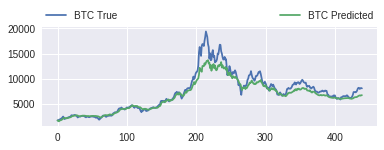

In [0]:
plt.subplot(211)
plt.plot(compare_rnn['BTC_true_price'], label='BTC True')
plt.plot(compare_rnn.iloc[:,1:], label = 'BTC Predicted')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

The predictions seem to be very good up until the moment when Bitcoin's price flew through the roof by the end of 2018. After that moment the predictions are somewhat off. To make a numeric comparison we have to calculate the root-mean-square-error of our prediction.

In [0]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse_rnn = sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_rescaled))

In [0]:
rmse_rnn

1195.1272430921324

We managed to achieve a RMSE of 1195$.

# Conclusion
The RMSE obtained by our Recurrent Neural Network is much worse than the one obtained by the VARMAX model. VARMAX achieved RMSE of 442 dollars and the RNN: 1195 dollars. The biggest problem for the RNN was the incredible growth of Bitcoin price and it did not cope with it very well. There is obviously much to improve in the neural network, like setting more fitting hyperparameters, and scaling the data in sliding windows, so that the huge increase would not be such a shock for net. However, in our case it seems that non of the two models were reliable enough to help making trading decisions, but there is still much to improve and probably if the test set would not contain such a huge increase in value, then our models would have done much better.